In [347]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import yfinance as yf


#assets (yfinance ticker)
asset1='BTC-USD'
asset2='ETH-USD'
pairs='BTC-ETH' #insert name of asset 1 and asset 2

#period of data collection
start_data='2017-12-01'
end_data='2022-07-31'

# comparison data
# compare with index 
#for tech stocks consider using QQQ or Nasdaq 100 or any other relevant index
#for crypto perhaps use bitcoin as index, cmc200, or QQQ (up to user judgement)
index_comp='BTC-USD'



#fetch log returns of pair (to model calibration)

X = yf.download(asset1, start = start_data, end=end_data)
X.reset_index(inplace=True)
X.tail()
X['Log_Returns'] = np.log(X['Adj Close']) - np.log(X['Adj Close'].shift(1))
x = X['Log_Returns'].drop(labels=0, axis=0)
date=X['Date'].drop(labels=0,axis=0)
date=date.to_frame()




Y = yf.download(asset2, start = start_data, end=end_data)
Y.reset_index(inplace=True)
Y.tail()
Y['Log_Returns'] = np.log(Y['Adj Close']) - np.log(Y['Adj Close'].shift(1))
y = Y['Log_Returns'].drop(labels=0, axis=0)

#fit distribution to element in pair + probability integral transform to get marginal uniform

param1 = stats.t.fit(x)
dist1=stats.t(*param1)
u=dist1.cdf(x)
param2=stats.t.fit(y)
dist2=stats.t(*param2)
v=dist2.cdf(y)



#put returns in a data frame with corresponding dates
x_df=x.to_frame()
y_df=y.to_frame()

a=y_df.rename(columns={'Log_Returns': asset2})
b=x_df.rename(columns={'Log_Returns': asset1})

p =a.join(b)
x=p.join(date)

returns_df=x.set_index('Date')


#fit bivariate copula family to data 
#calculate Akaike information criterion, Bayesion information criterion and KS value to help determine good fit

from co import *
import ndtest

pair=[pairs]
copulas_df = pd.DataFrame(index=pair, columns=['copula', 'parameter', 'aic', 'bic', 'KS_pvalue'])


best_aic = np.inf
best_copula= None


copulas=[GaussianCopula(),GumbelCopula(), ClaytonCopula(),FrankCopula()]
for copula in copulas:
    copula.fit(u,v)

    L = copula.log_likelihood(u,v)
    aic = 2 * copula.num_params - 2 * L
    if aic < best_aic:
        best_aic = aic
        best_bic = copula.num_params * np.log(len(u)) - 2 * L
        best_copula = copula

        # calculate KS-pvalue
        smp = copula.sample(size=len(u)) # generate sample from fit copula
        s_u = smp[:,0]
        s_v = smp[:,1]
        ks_pval = ndtest.ks2d2s(u,v,s_u,s_v)

        if isinstance(copula, ArchimedeanCopula):
            best_param = copula.alpha
        else:
            best_param = copula.rho

copulas_df.loc[pair] = [best_copula.name, best_param, best_aic, best_bic, ks_pval]
copulas_df



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,copula,parameter,aic,bic,KS_pvalue
BTC-ETH,Gaussian,0.830403,-2138.918724,-2133.478577,0.022097


In [348]:
from datetime import date, timedelta
trade_dates=[]
start_date = date(2020, 1, 1)
end_date = date(2022, 8, 18)
delta = timedelta(days=30)
while start_date <= end_date:
    trade_dates.append(start_date.strftime("%Y-%m-%d"))
    start_date += delta


In [349]:
tot_return=[]
#dataframe of the returns for the specific trading period 
for d in range(0,len(trade_dates)-1):
    X_trade = yf.download(asset1, start =trade_dates[d], end=trade_dates[d+1])

    X_trade.reset_index(inplace=True)
    X_trade.tail()
    X_trade['Log_Returns'] = np.log(X_trade['Adj Close']) - np.log(X_trade['Adj Close'].shift(1))
    x_trade = X_trade['Log_Returns'].drop(labels=0, axis=0)
    date=X_trade['Date'].drop(labels=0,axis=0)
    date=date.to_frame()

    Y_trade = yf.download(asset2, start = trade_dates[d], end=trade_dates[d+1])
    Y_trade.reset_index(inplace=True)
    Y_trade.tail()
    Y_trade['Log_Returns'] = np.log(Y_trade['Adj Close']) - np.log(Y_trade['Adj Close'].shift(1))
    y_trade = Y_trade['Log_Returns'].drop(labels=0, axis=0)


    #put returns in a data frame with corresponding dates
    x2_df=x_trade.to_frame()
    y2_df=y_trade.to_frame()

    m=y2_df.rename(columns={'Log_Returns': asset2})
    a=x2_df.rename(columns={'Log_Returns': asset1})

    p =m.join(a)
    x=p.join(date)

    returns_trade_period=x.set_index('Date')

    

# exit trade when pair reverts to historical relationship
# close position using criteria from'Pairs trading: A copula approach' - Liew, Wu, 2013
# paper link: https://link.springer.com/content/pdf/10.1057/jdhf.2013.1.pdf
# close positions when conditional probabilies cross boundery of 0.5

# rules for opening positions
# short position -> P(U<= u | V=v) >=c *A overpriced* AND P(V<= v | U=u) <=(1-c) *B underpriced*
# long position -> P(U<= u | V=v) <=(1-c) *A underpriced* AND P(V<= v | U=u) >=(c) *B overpriced*

    # calculate conditional probabilities
    prob1=[]
    prob2=[]

    algo_returns = {}
    cl = 0.95

    for u,v in zip(dist1.cdf(returns_trade_period[asset1]), dist2.cdf(returns_trade_period[asset2])):
        prob1.append(best_copula.cdf_u_given_v(u,v))
        prob2.append(best_copula.cdf_v_given_u(u,v))


    probs_trade= pd.DataFrame(np.vstack([prob1,prob2]).T,index=returns_trade_period.index, columns=[asset1,asset2])



    #calculate positions
    positions=pd.DataFrame(index=probs_trade.index, columns = probs_trade.columns)
    long = False
    short = False


    for t in positions.index:    
        # if long position is open
        if long:
            if (probs_trade.loc[t][asset1] > 0.5) or (probs_trade.loc[t][asset2] < 0.5):
                positions.loc[t] = [0,0]
                long = False
            else:
                positions.loc[t] = [1,-1]

        # if short position is open
        elif short:
            if (probs_trade.loc[t][asset1] < 0.5) or (probs_trade.loc[t][asset2] > 0.5):
                positions.loc[t] = [0,0]
                short = False
            else:
                positions.loc[t] = [-1,1]

        # if no positions are open
        else:
            if (probs_trade.loc[t][asset1] < (1-cl)) and (probs_trade.loc[t][asset2] > cl):
                # open long position
                positions.loc[t] = [1,-1]
                long = True
            elif (probs_trade.loc[t][asset1] > cl) and (probs_trade.loc[t][asset2] < (1-cl)):
                # open short positions
                positions.loc[t] = [-1,1]
                short = True
            else:
                positions.loc[t] = [0,0]


    # calculate returns
    algo_ret = (returns_trade_period * positions.shift()).sum(axis=1)
    algo_returns[pairs] = algo_ret
    
    returns = pd.DataFrame.from_dict(algo_returns)
    returns = np.exp(returns) - 1 # convert log-returns to simple returns
    total_ret = returns.sum(axis=1) / len(returns.columns) * 2 # double capital (from short positions)

    def total_return(cumret):
        total_return = (cumret[-1] - cumret[0])/cumret[0]
        return total_return

    x=total_return(np.nancumprod(total_ret + 1))
    tot_return.append(x)




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [350]:
index=tot_return.index(max(tot_return))
optimal_start_date=trade_dates[index]
optimal_end_date=trade_dates[index+1]
print('Highest 30 day return of algo:',max(tot_return),'This occured on:',optimal_start_date,'-',optimal_end_date)

index=tot_return.index(min(tot_return))
worst_start_date=trade_dates[index]
worst_end_date=trade_dates[index+1]
print('Lowest 30 day return of algo:',min(tot_return),'This occured on:',worst_start_date,'-',worst_end_date)

Highest 30 day return of algo: 0.4203248087122491 This occured on: 2021-04-25 - 2021-05-25
Lowest 30 day return of algo: -0.1707582088470857 This occured on: 2021-08-23 - 2021-09-22


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


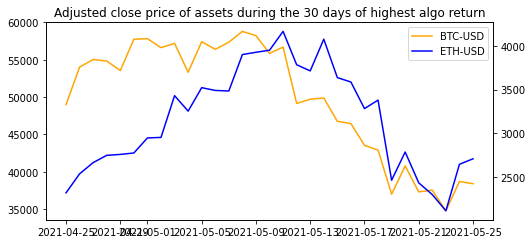

In [359]:
#plot of two asset prices for time interval with best algo return
asset1_price = yf.download(asset1, start=optimal_start_date, end=optimal_end_date)
asset1_price = asset1_price['Adj Close']

asset2_price = yf.download(asset2, start=optimal_start_date, end=optimal_end_date)
asset2_price = asset2_price['Adj Close']

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True


ax1 = plt.subplot()
l1, = ax1.plot(asset1_price, color='orange')
ax2 = ax1.twinx()
l2, = ax2.plot(asset2_price, color='blue')

plt.legend([l1, l2], [asset1, asset2])
plt.title('Adjusted close price of assets during the 30 days of highest algo return')
plt.show()

In [352]:
x=yf.download(asset1, start=trade_dates[0], end=trade_dates[-1], interval = "1d")
x.ta.vwap(append=True).dropna()
b=x['VWAP_D']

y=yf.download(asset2, start=trade_dates[0], end=trade_dates[-1], interval = "1d")
y.ta.vwap(append=True).dropna()
e=y['VWAP_D']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


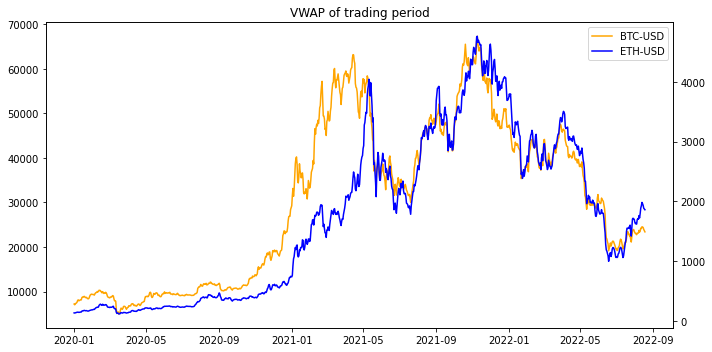

In [360]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True


ax1 = plt.subplot()
l1, = ax1.plot(b, color='orange')
ax2 = ax1.twinx()
l2, = ax2.plot(e, color='blue')
plt.title('VWAP of trading period')
plt.legend([l1, l2], [asset1, asset2])
plt.show()


In [366]:
variance_b=[]
variance_e=[]
corr=[]
for i in range(0,len(trade_dates)-1):
    x=b[trade_dates[i]:trade_dates[i+1]]
    variance_b.append(round(x.var()))
    y=e[trade_dates[i]:trade_dates[i+1]]
    variance_e.append(y.var())
    corr.append(x.corr(y))
title1='Variance '+ asset1+' VWAP'
title2='Variance '+ asset2+' VWAP'
var={'total return':tot_return, title1 :variance_b,title2:variance_e,'Correlation':corr}
df=pd.DataFrame(var)
months=trade_dates[1:]
months=pd.Series(months)

df=df.merge(months.rename('trading month'), left_index=True, right_index=True)
df=df.set_index(['trading month'])
df

,total return,Variance BTC-USD VWAP,Variance ETH-USD VWAP,Correlation
trading month,,,,
2020-01-31,-0.011429,426633,263.879685,0.964520
2020-03-01,-0.102155,226197,944.160638,0.502995
2020-03-31,0.157019,1844503,2061.051717,0.974514
2020-04-30,0.000000,274794,464.780665,0.899882
2020-05-30,-0.035034,122435,89.076797,0.437110
2020-06-29,0.000000,48346,39.798482,0.912699
2020-07-29,0.010196,272790,886.396796,0.918441
2020-08-28,-0.010912,71103,733.491316,0.840788
2020-09-27,0.101146,245028,1068.923070,0.836269


In [369]:
df_varbtc=df.sort_values(by=[title1])
highlight_df_varbtc=df_varbtc.style.apply(lambda x: ['background: lightgreen' if x.name == optimal_end_date else '' for i in x], 
               axis=1)
print('Table sorted by ascending variance of ',asset1, ' VWAP')
print('maximum total return row highlighted')
highlight_df_varbtc

Table sorted by ascending variance of  BTC-USD  VWAP
maximum total return row highlighted


,total return,Variance BTC-USD VWAP,Variance ETH-USD VWAP,Correlation
trading month,,,,
2020-06-29,0.000000,48346,39.798482,0.912699
2020-08-28,-0.010912,71103,733.491316,0.840788
2020-05-30,-0.035034,122435,89.076797,0.437110
2020-03-01,-0.102155,226197,944.160638,0.502995
2020-09-27,0.101146,245028,1068.923070,0.836269
2020-07-29,0.010196,272790,886.396796,0.918441
2020-04-30,0.000000,274794,464.780665,0.899882
2020-01-31,-0.011429,426633,263.879685,0.964520
2022-08-18,0.000000,579741,22176.735341,0.877170


In [371]:
df_vareth=df.sort_values(by=[title2])
highlight_df_vareth=df_vareth.style.apply(lambda x: ['background: lightgreen' if x.name == optimal_end_date else '' for i in x], 
               axis=1)
print('Table sorted by ascending variance of ',asset2, ' VWAP')
print('maximum total return row highlighted')

highlight_df_vareth

Table sorted by ascending variance of  ETH-USD  VWAP
maximum total return row highlighted


,total return,Variance BTC-USD VWAP,Variance ETH-USD VWAP,Correlation
trading month,,,,
2020-06-29,0.000000,48346,39.798482,0.912699
2020-05-30,-0.035034,122435,89.076797,0.437110
2020-01-31,-0.011429,426633,263.879685,0.964520
2020-10-27,0.059263,835249,457.079487,0.944750
2020-04-30,0.000000,274794,464.780665,0.899882
2020-08-28,-0.010912,71103,733.491316,0.840788
2020-07-29,0.010196,272790,886.396796,0.918441
2020-03-01,-0.102155,226197,944.160638,0.502995
2020-09-27,0.101146,245028,1068.923070,0.836269


In [372]:
df_corr=df.sort_values(by=['Correlation'])
highlight_df_corr=df_corr.style.apply(lambda x: ['background: lightgreen' if x.name == optimal_end_date else '' for i in x], 
               axis=1)
highlight_df_corr

,total return,Variance BTC-USD VWAP,Variance ETH-USD VWAP,Correlation
trading month,,,,
2021-04-25,-0.103022,13094144,50955.293706,0.107021
2020-05-30,-0.035034,122435,89.076797,0.437110
2020-03-01,-0.102155,226197,944.160638,0.502995
2021-05-25,0.420325,61471772,363468.686325,0.524828
2021-06-24,-0.053890,4599005,65926.739303,0.672077
2021-09-22,-0.170758,5159748,74610.016328,0.741271
2021-12-21,-0.030427,19470090,49719.457511,0.785739
2021-01-25,-0.015614,16558203,54479.866764,0.792962
2021-11-21,0.000000,5567115,51969.752805,0.800002


In [374]:
print('Appears that low 30-day rolling correlation and high individual VWAP variance makes for better algo returns')

Appears that low 30-day rolling correlation and high individual VWAP variance makes for better algo returns
